This notebook will describe the process of extracting coincident events in a certain run. Refer to notebook named `MAGNITUDE_DETECTORS` and `MAGNITUDE_ICPC`. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#importing the excel files after the magnitude calculations 

df = pd.read_excel('magnitude_discharge_bege-Copy1.xlsx')
df1 = pd.read_excel('magnitude_discharge_coax-Copy1.xlsx')
df2 = pd.read_excel('magnitude_discharge_icpc-Copy1.xlsx')
df3 = pd.read_excel('magnitude_discharge_ppc-Copy1.xlsx')

d = pd.read_excel('magnitude_microdischarge_bege-Copy1.xlsx')
d1 = pd.read_excel('magnitude_microdischarge_coax-Copy1.xlsx')
d2 = pd.read_excel('magnitude_microdischarge_icpc-Copy1.xlsx')
d3 = pd.read_excel('magnitude_microdischarge_ppc-Copy1.xlsx')

#used to print all the rows and columns in the data set 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [2]:
#combining all discharge and microdischagre events 
df_total = pd.concat([df, df1, df2, df3,d,d1,d2,d3])

In [3]:
#grouping the detectors by the unique events 
df_total= df_total.groupby('Detector Name')['Event'].unique().to_dict()

In [4]:
import pygama
import pygama.lh5 as lh5
import matplotlib.pyplot as plt
import numpy as np
import h5py
from pygama.dsp.processors import pole_zero
plt.rcParams['figure.figsize'] = [10, 10]
import json
from scipy.stats import zscore
from scipy.optimize import curve_fit

In [5]:
new_raw = f'/unix/legend/wquinn/discharges/raw_files/ '
sto = lh5.Store() # we require this to read 
fw_new1=f'/unix/legend/wquinn/discharges/raw_files/l200-p06-r007-tst-20230726T054554Z_tier_raw.lh5'

In [6]:
f = open('channel_maps.json','r')
cmap = json.load(f)

In [7]:
targets = ["bege","ppc","icpc","coax"]
matching_targets=[]
for i in targets:
    matching_bege = [key for key, value in cmap.items() if "type" in value and value["type"] == i]
    matching_targets.append(matching_bege)

In [8]:
ch = "ch"

all_detectors = [ch + element for sublist in matching_targets for element in sublist]

In [9]:
tb_data_all = {}  
wfs_all_all = {}  

for j in all_detectors:
    tb_data_all[j] = sto.read_object(f'/{j}/raw', fw_new1)[0]
    wfs_all_all[j] = tb_data_all[j]['waveform']['values'].nda

In [10]:
flat_list = [item for sublist in matching_targets for item in sublist] #flattens the list matching targets which is a list of lists

In [11]:
location={}

for i in flat_list:
    if i in cmap: #checking if the detctor is in the json files
        target_value = cmap[i] 
        location_info = cmap[i].get('location', {}) #extracts the location information for the detector 
        location["ch"+i]=location_info #adding ch to the detector number 
        
        # Extract 'string' and 'position' from the 'location' dictionary
        string_value = location_info.get('string', None)
        position_value = location_info.get('position', None)
        

        if string_value is not None and position_value is not None:
            print(f"For detector: {i}, Location - String: {string_value}, Position: {position_value}")
        else:
            print(f"Location information not complete for detector: {i}")
    else:
        print(f"Detector: {i} not found in the dictionary.")

For detector: 1107202, Location - String: 2, Position: 1
For detector: 1110402, Location - String: 3, Position: 1
For detector: 1110403, Location - String: 3, Position: 2
For detector: 1112005, Location - String: 4, Position: 1
For detector: 1113600, Location - String: 4, Position: 2
For detector: 1113601, Location - String: 4, Position: 3
For detector: 1113602, Location - String: 4, Position: 4
For detector: 1113603, Location - String: 4, Position: 5
For detector: 1113604, Location - String: 4, Position: 6
For detector: 1113605, Location - String: 4, Position: 7
For detector: 1120003, Location - String: 8, Position: 1
For detector: 1120004, Location - String: 8, Position: 2
For detector: 1078405, Location - String: 9, Position: 1
For detector: 1080000, Location - String: 9, Position: 2
For detector: 1080001, Location - String: 9, Position: 3
For detector: 1080002, Location - String: 9, Position: 4
For detector: 1083200, Location - String: 9, Position: 14
For detector: 1083201, Locatio

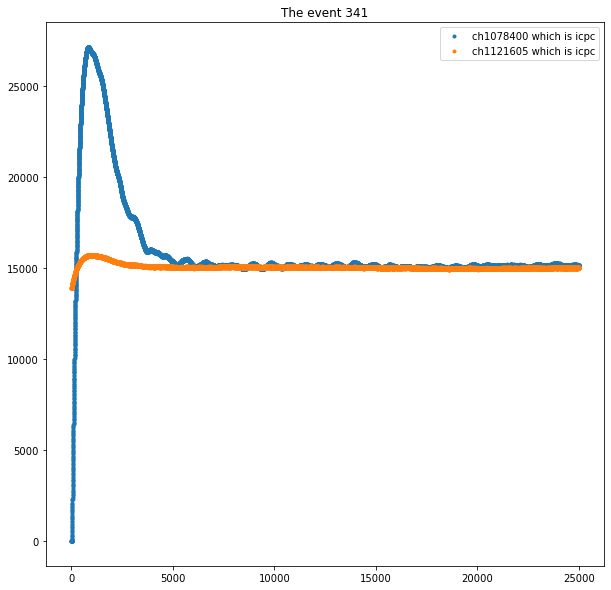

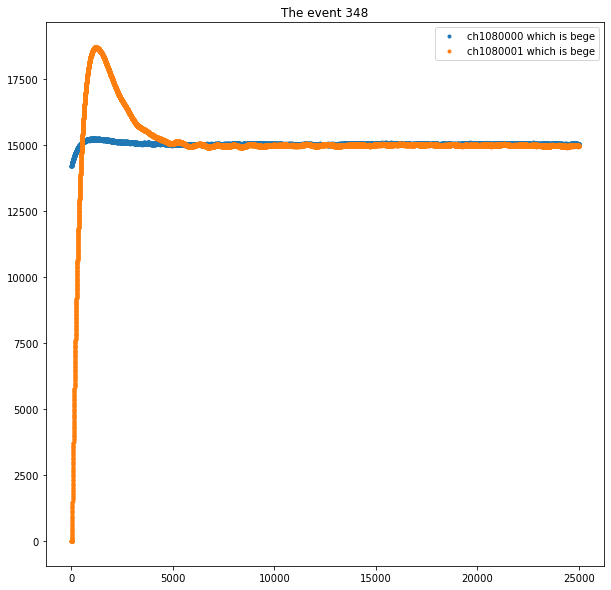

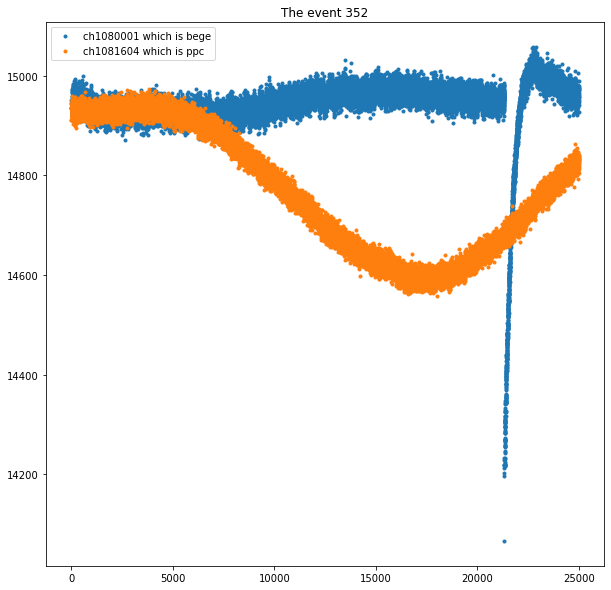

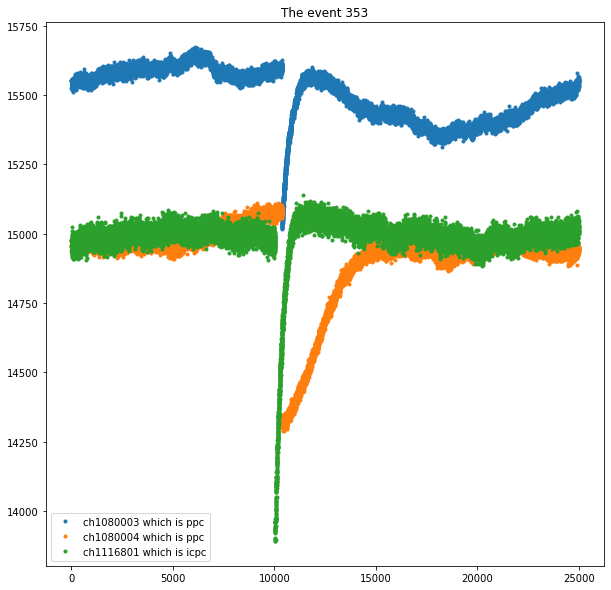

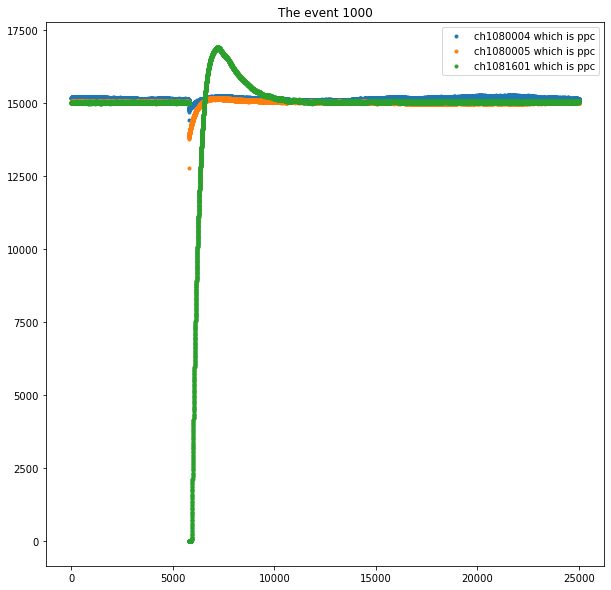

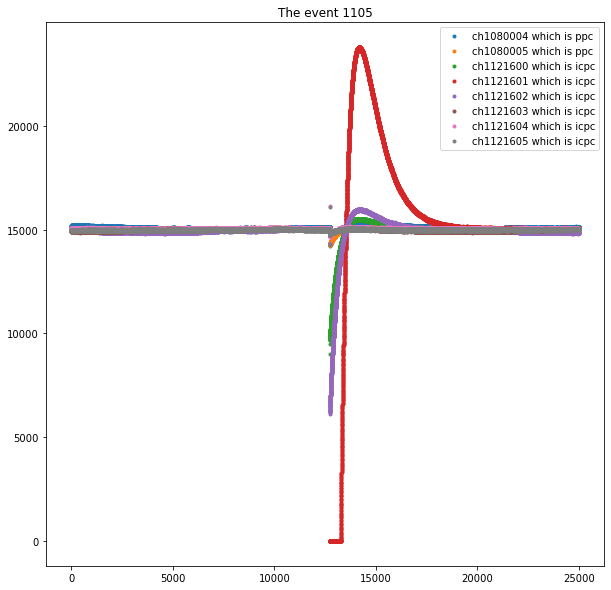

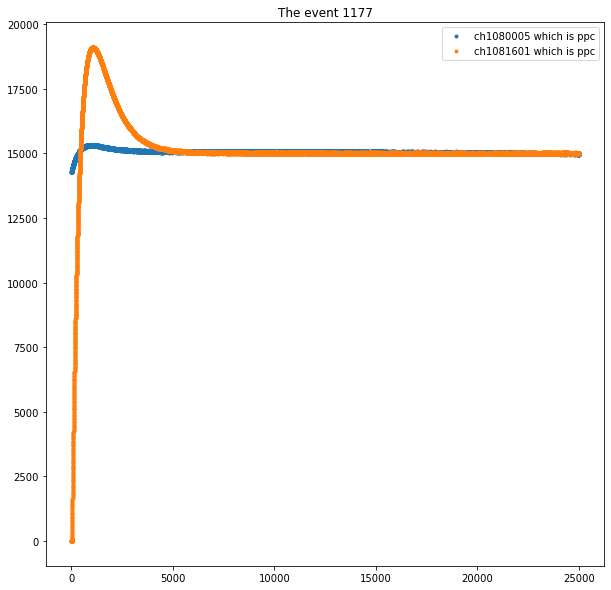

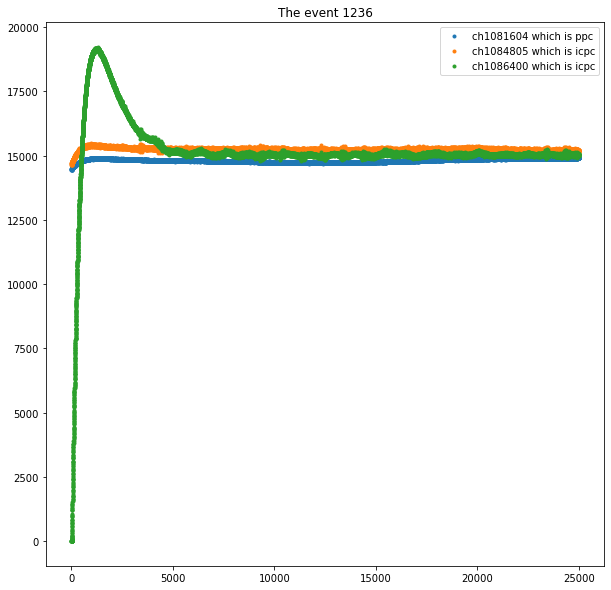

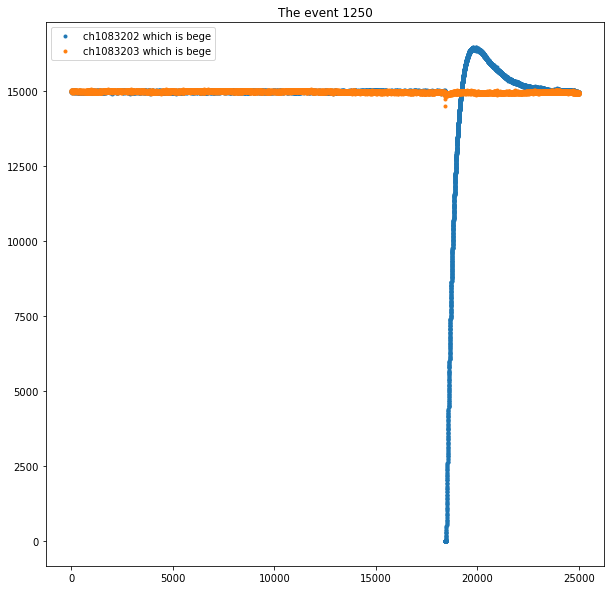

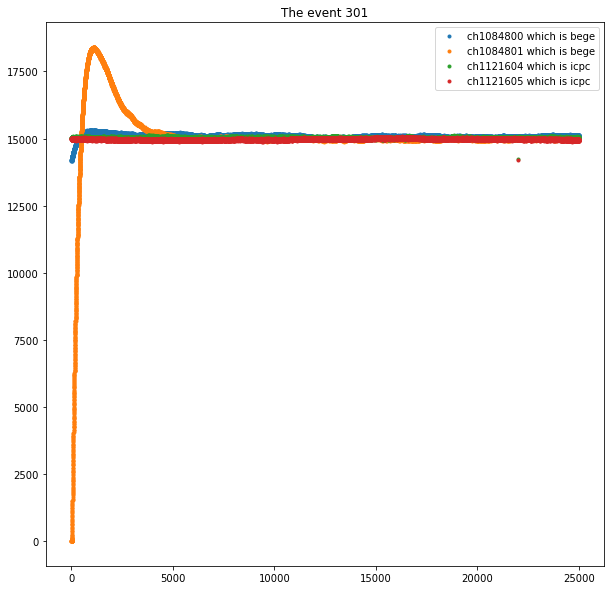

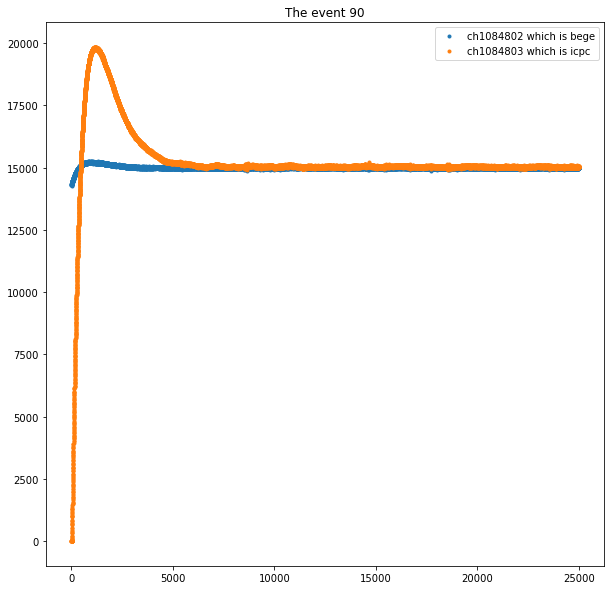

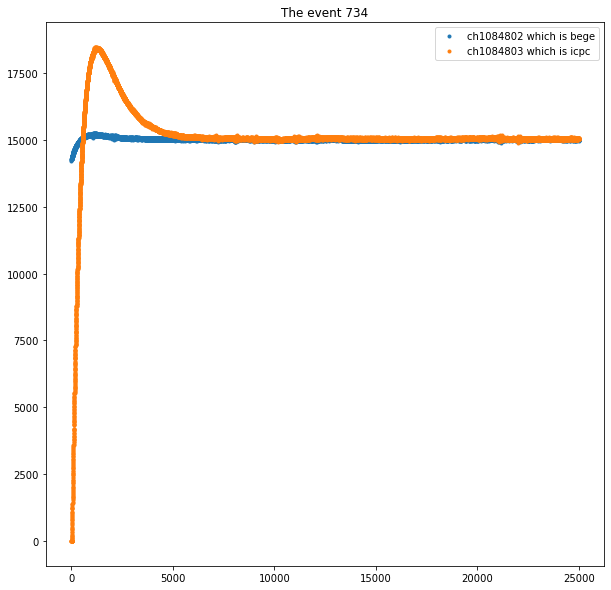

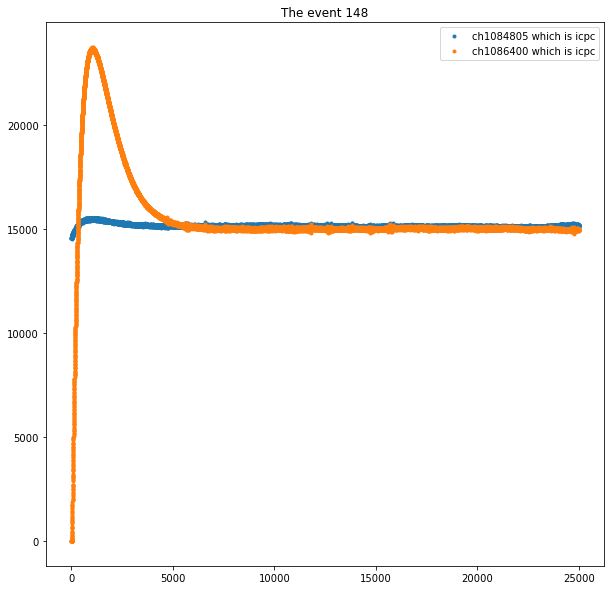

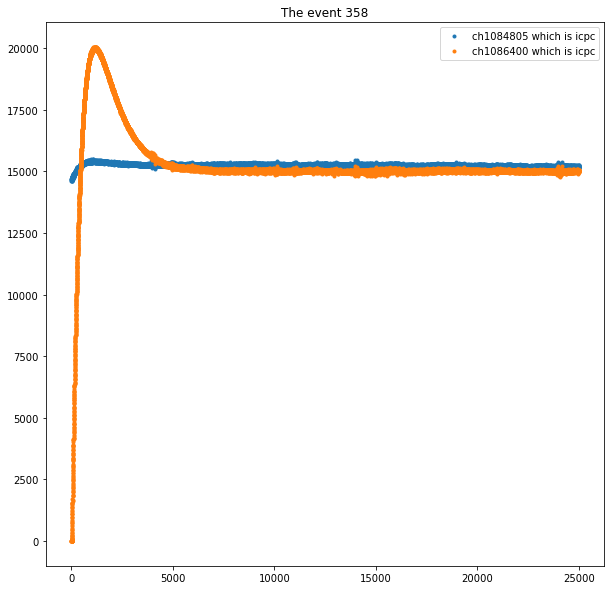

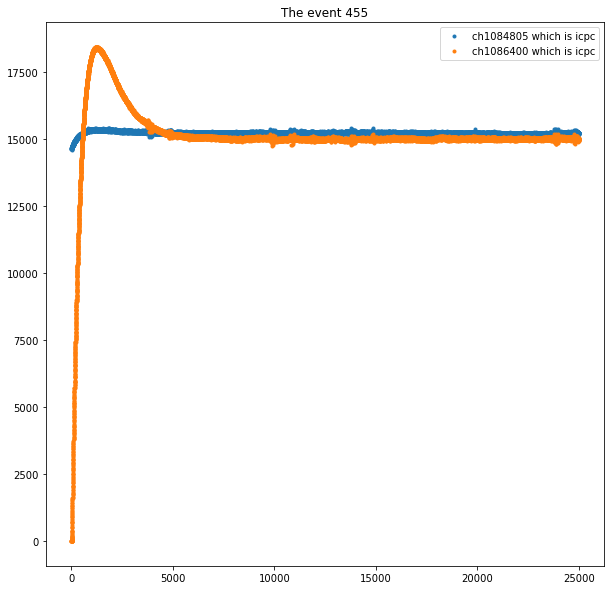

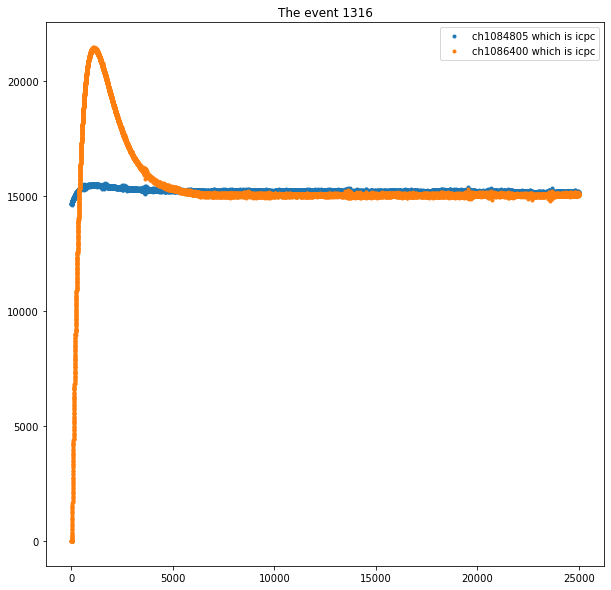

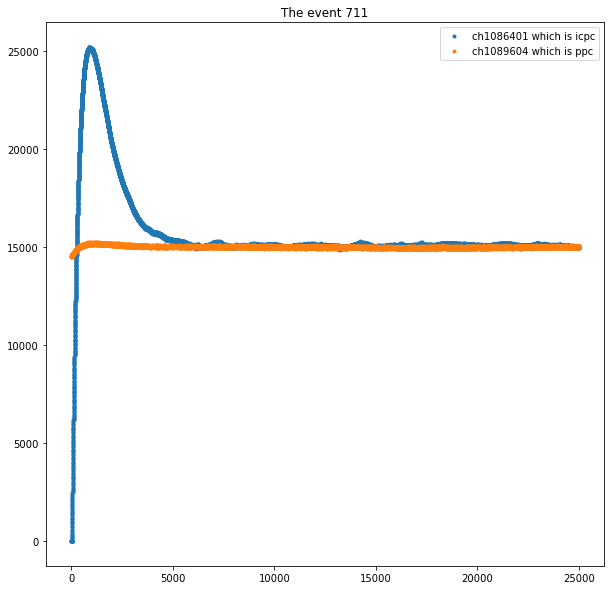

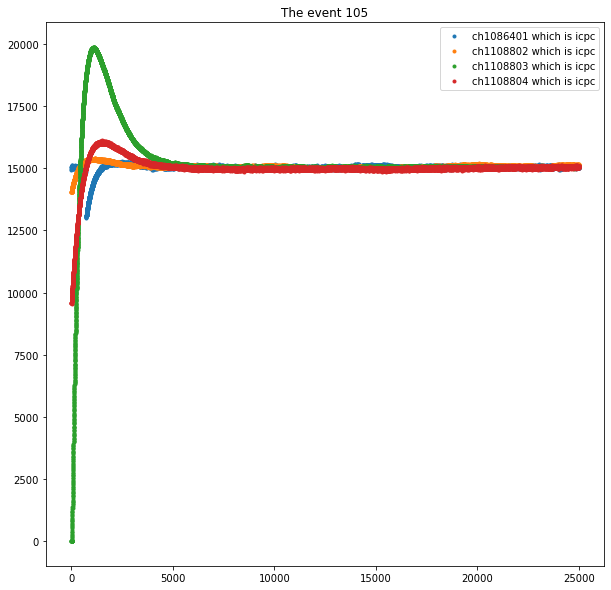

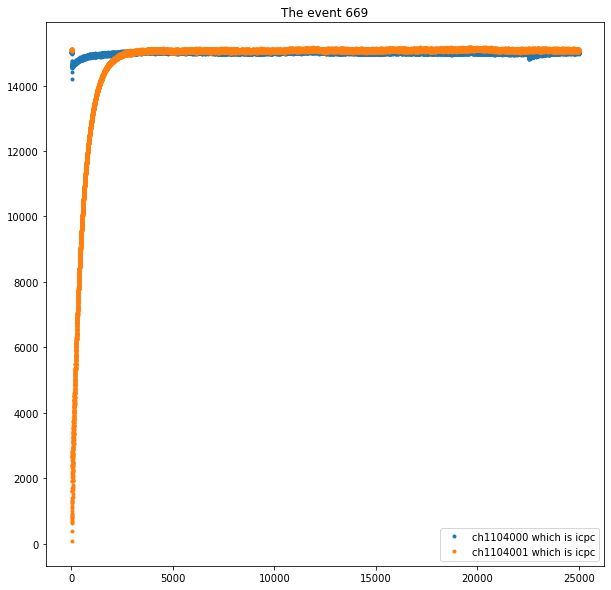

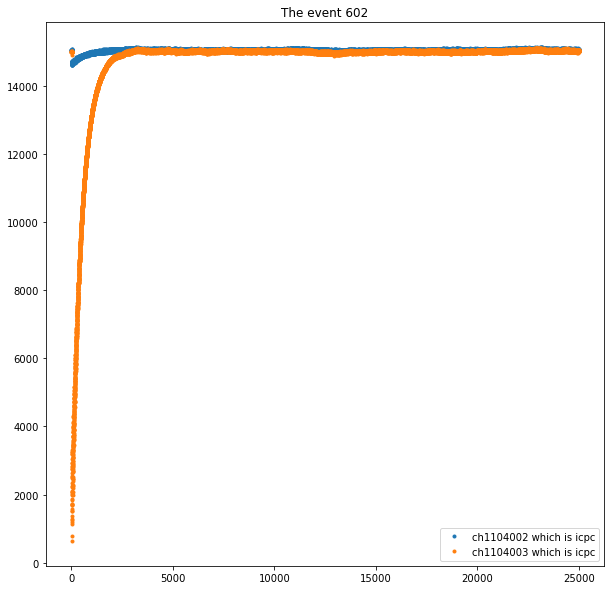

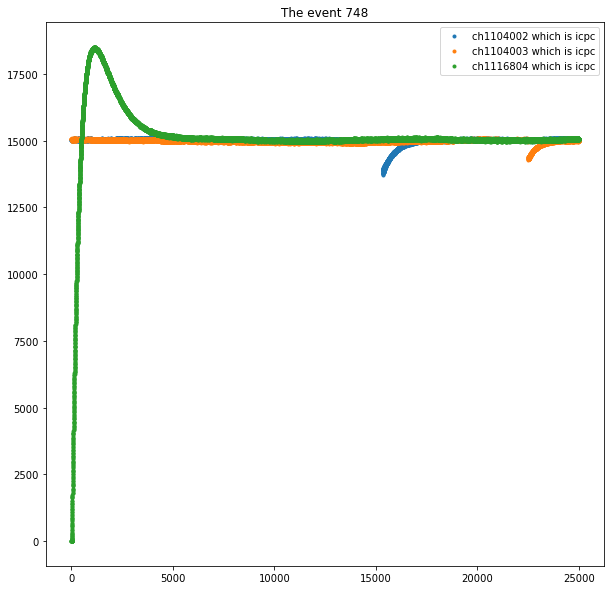

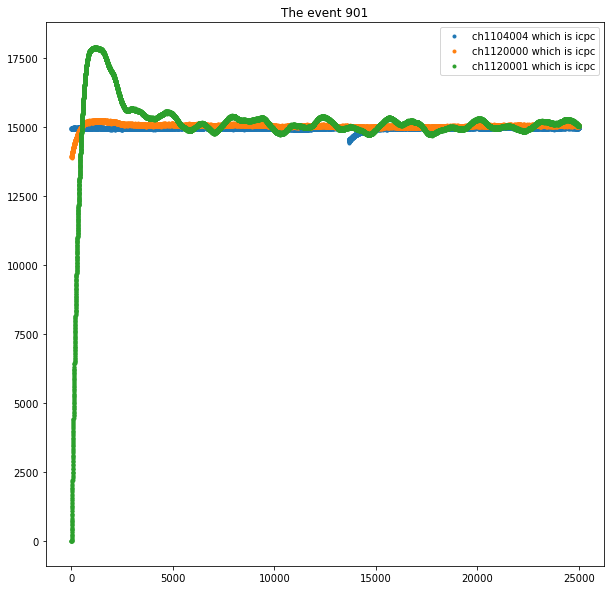

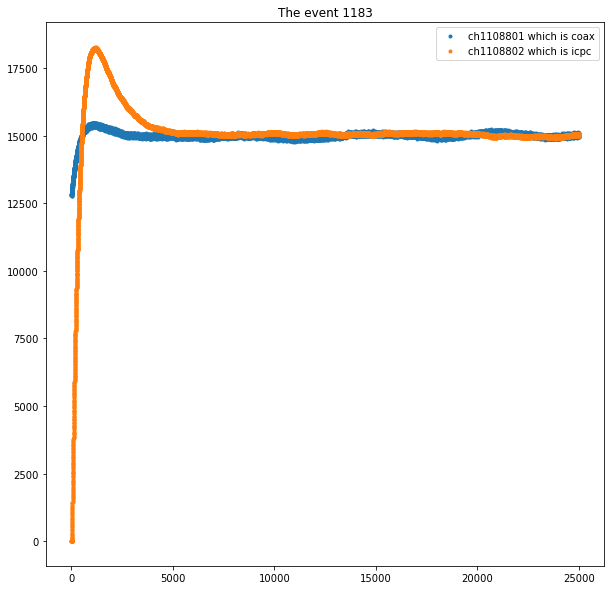

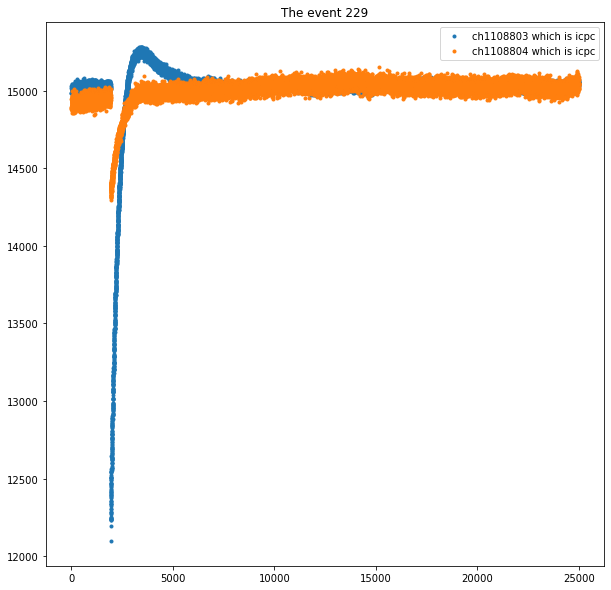

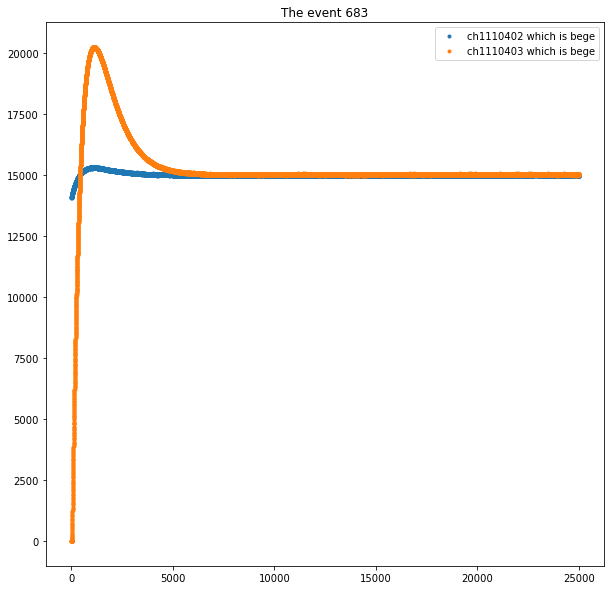

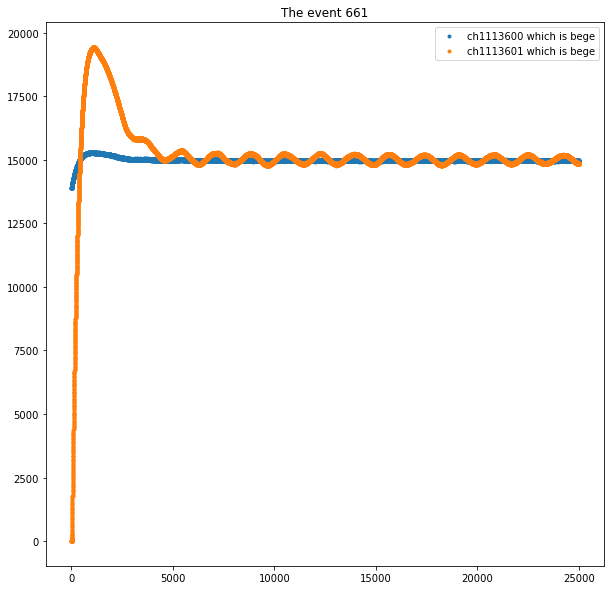

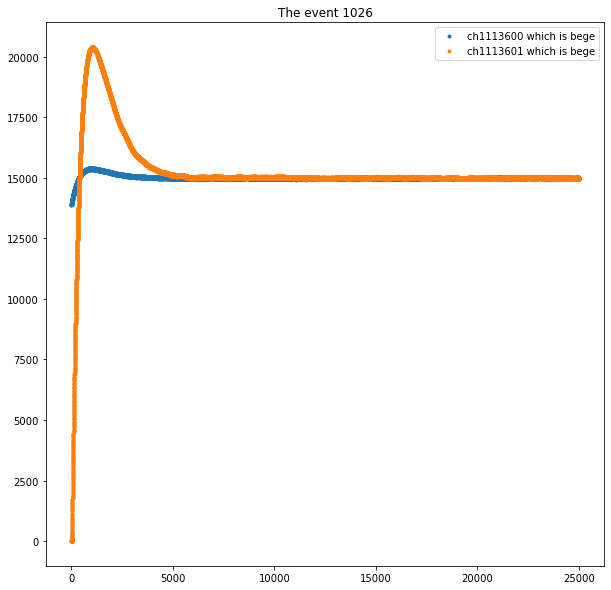

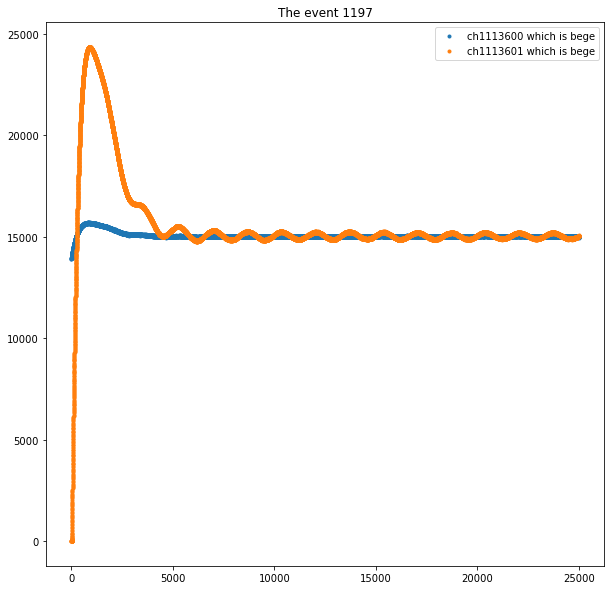

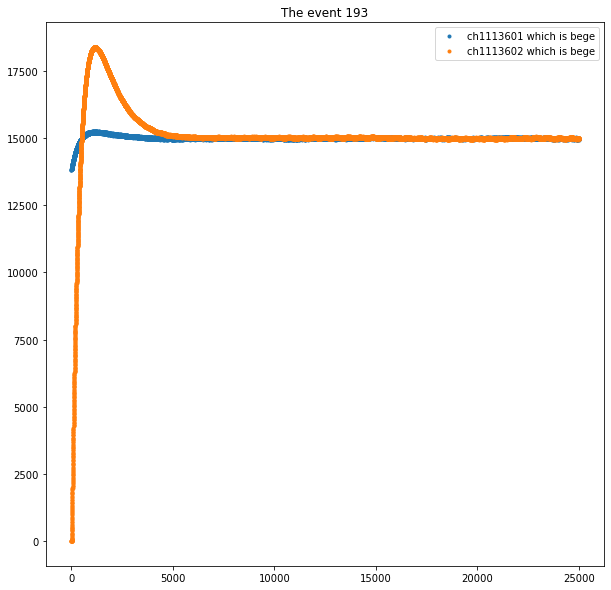

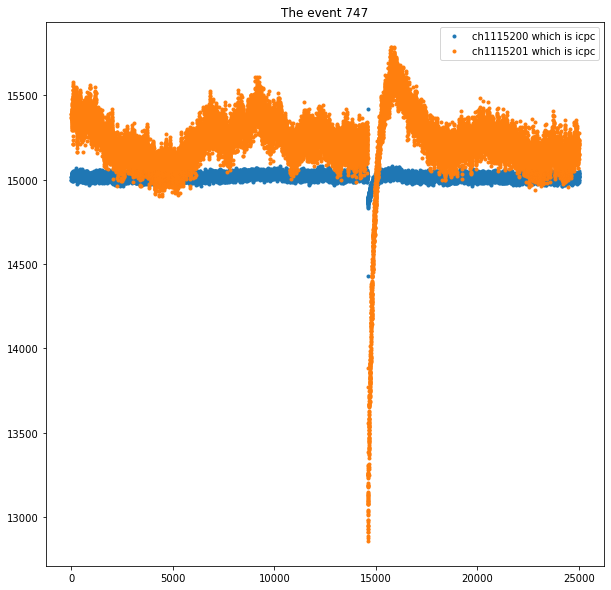

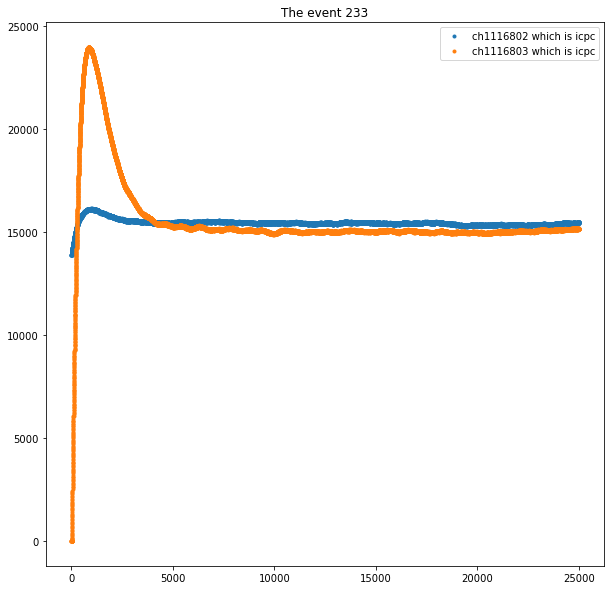

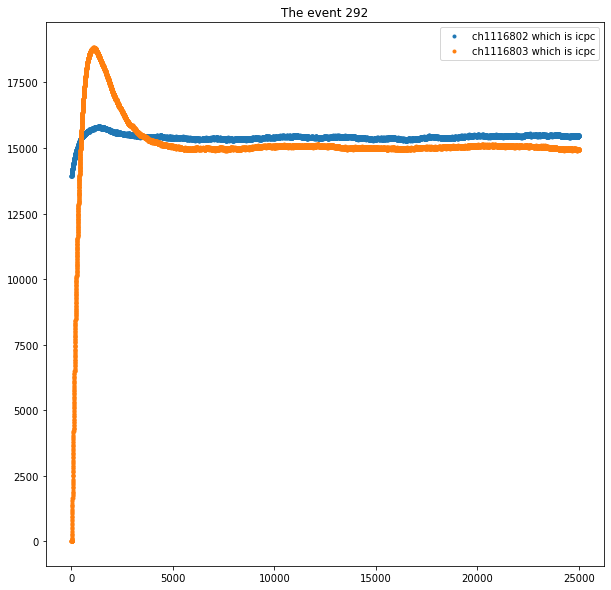

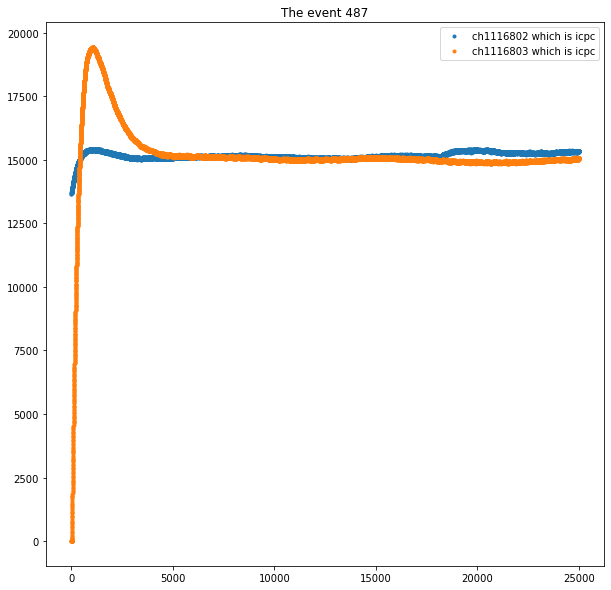

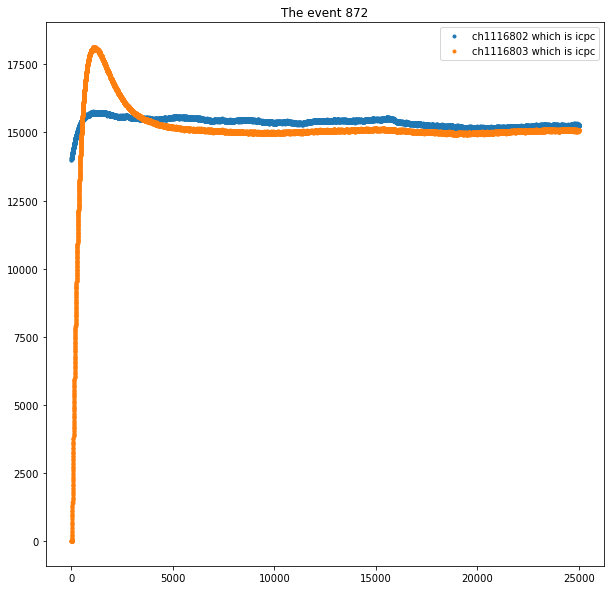

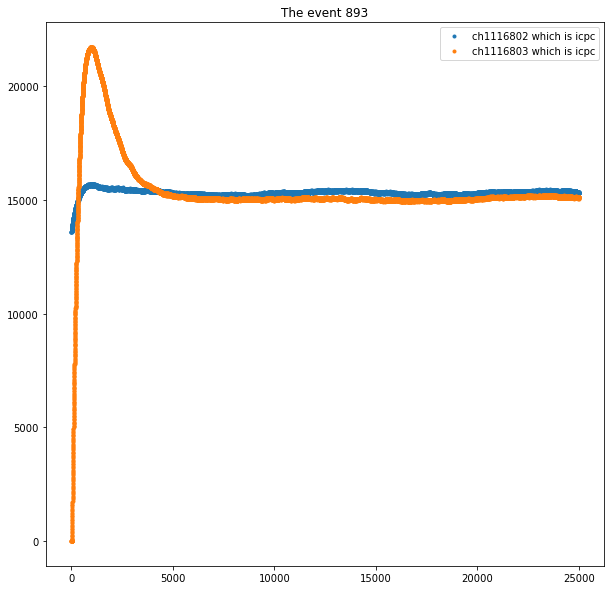

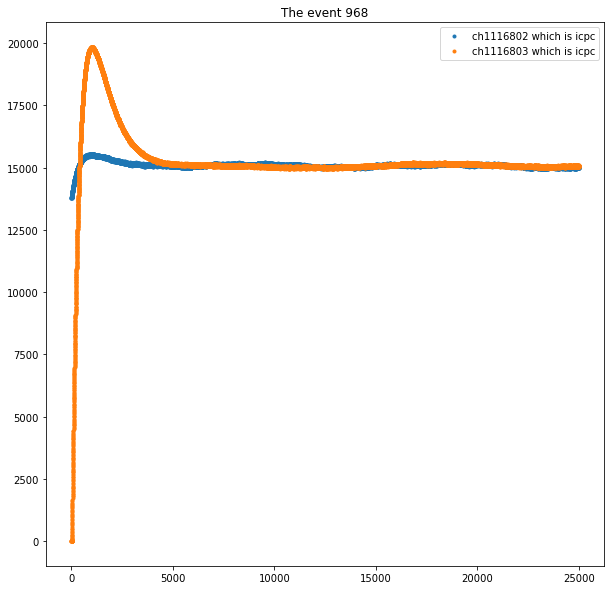

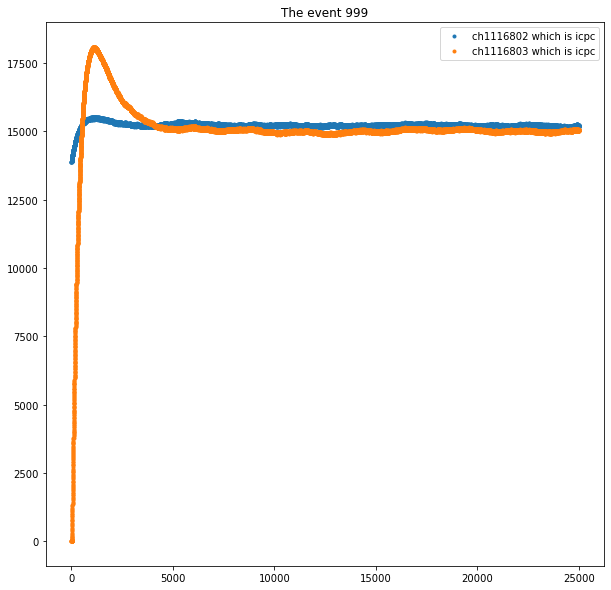

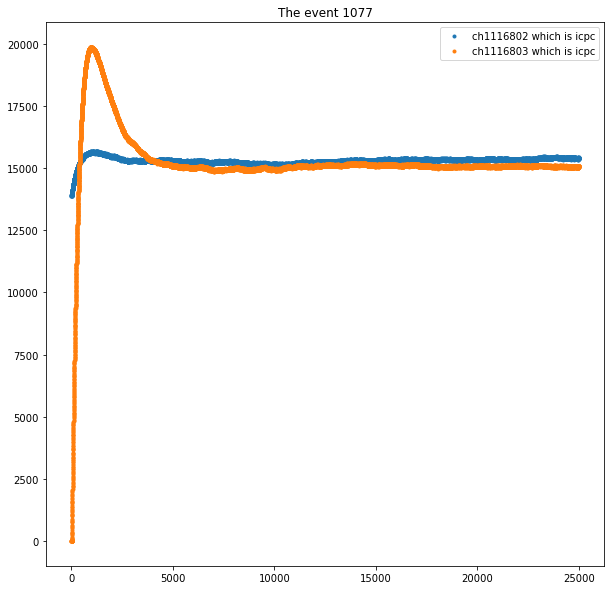

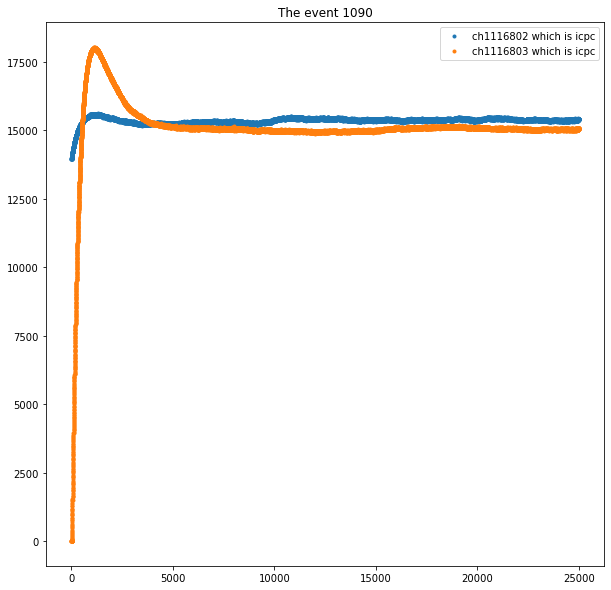

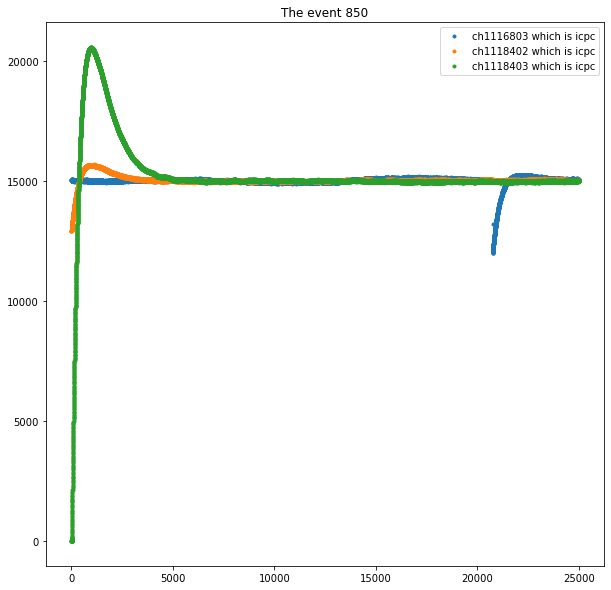

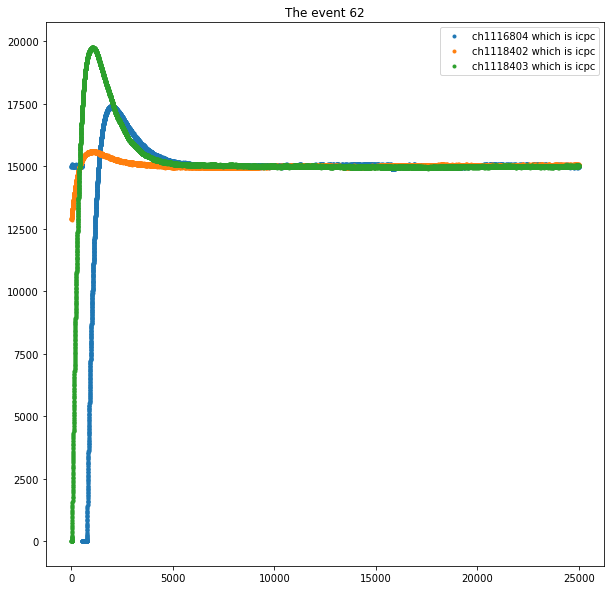

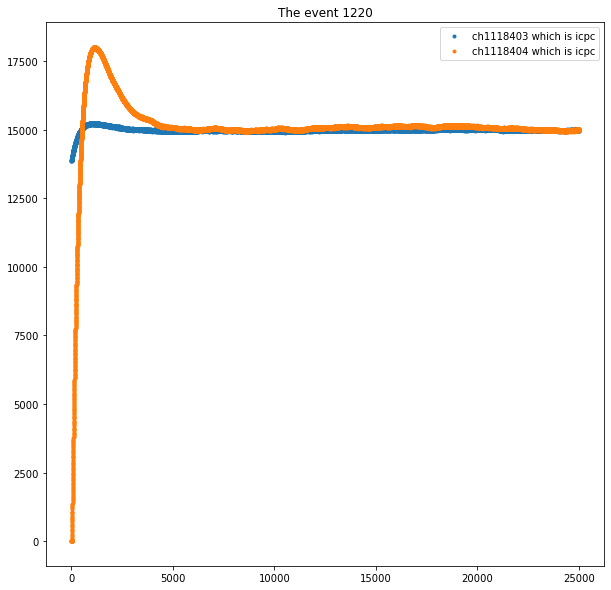

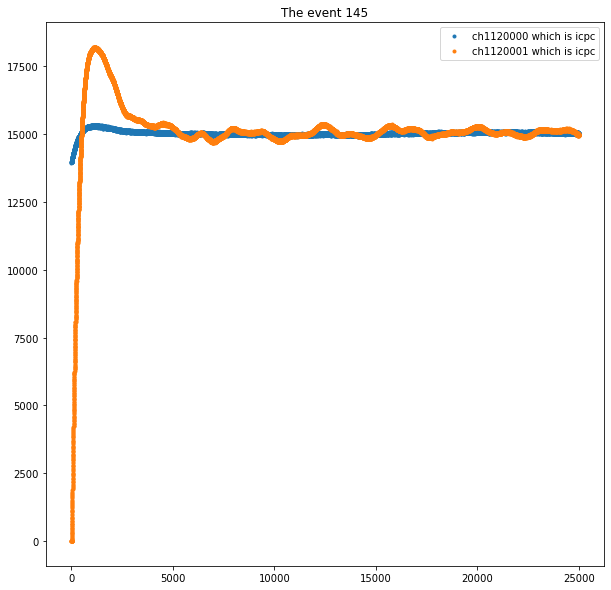

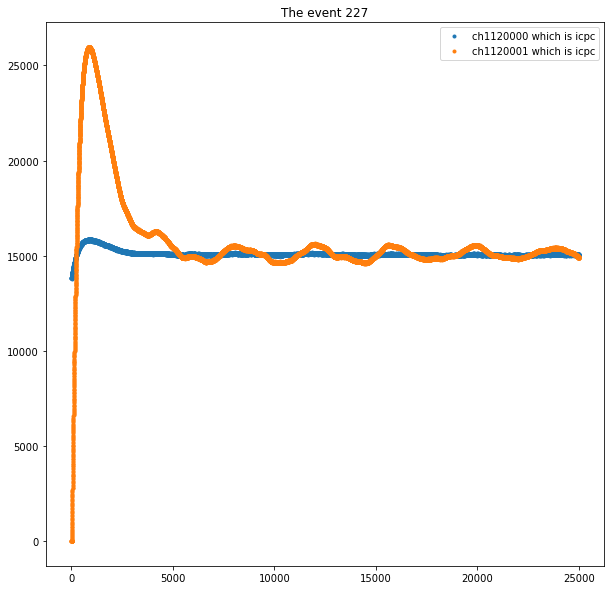

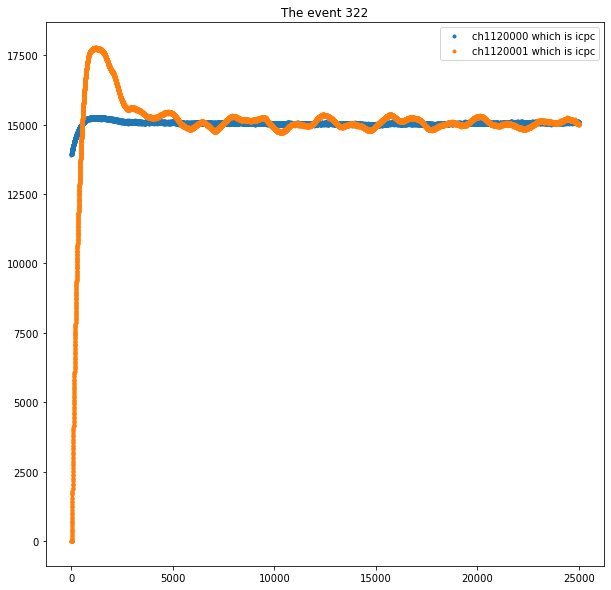

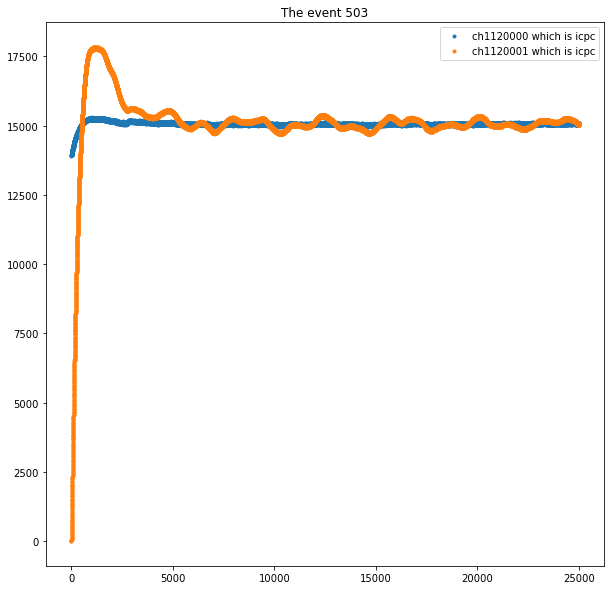

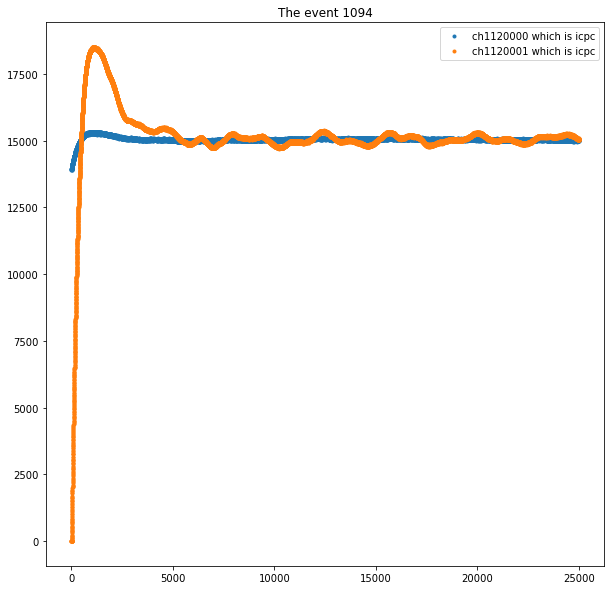

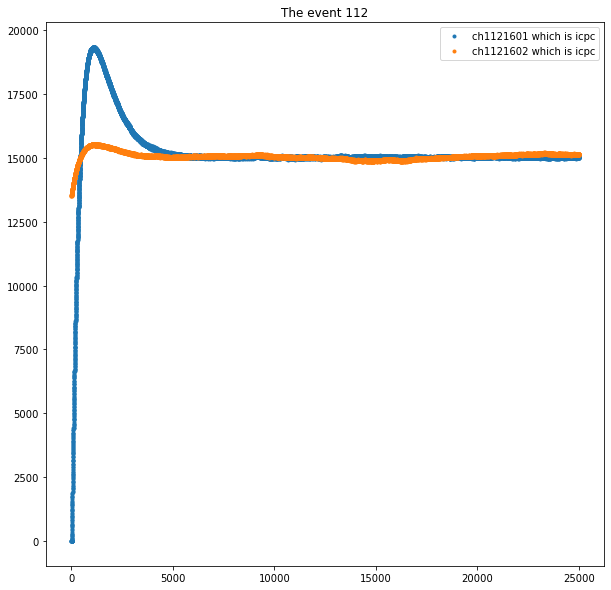

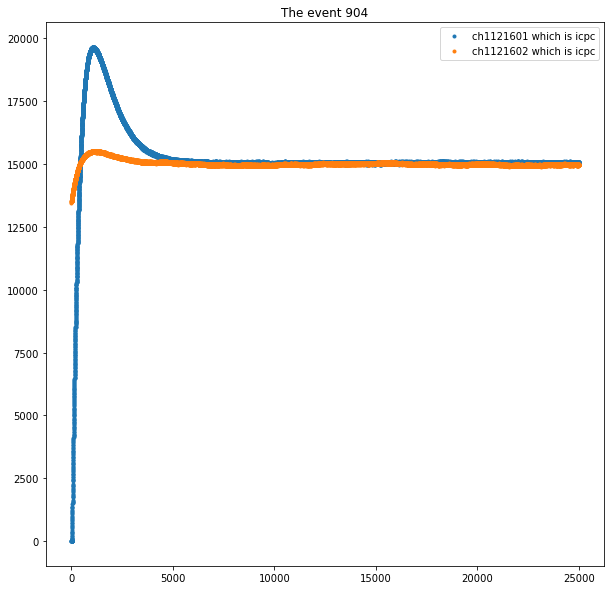

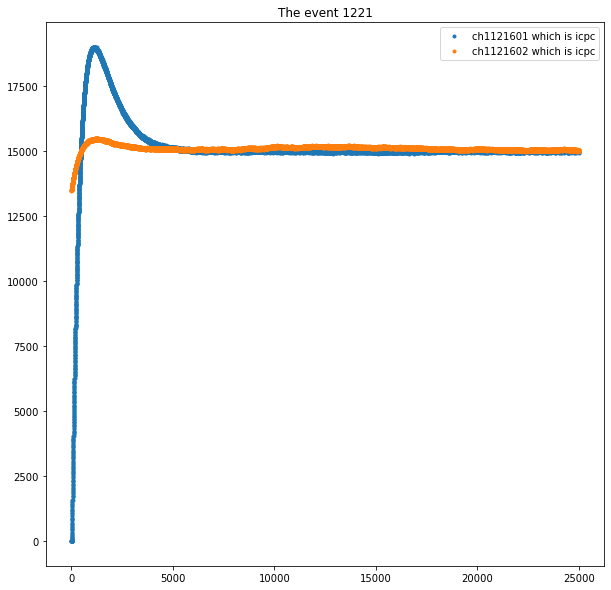

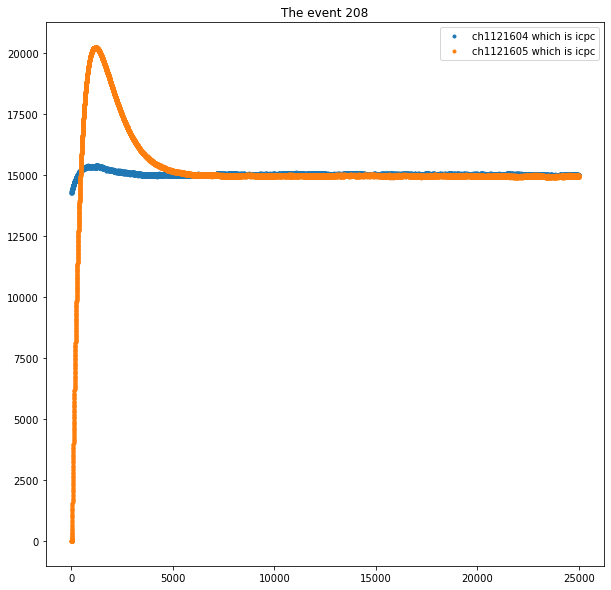

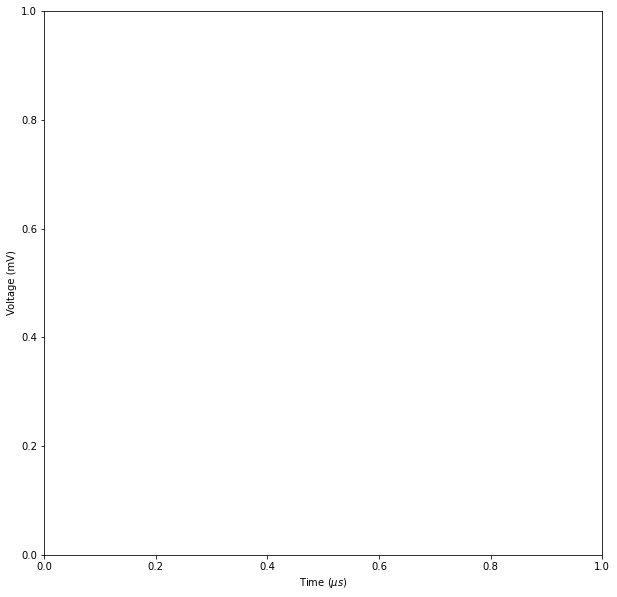

In [12]:
import pandas as pd

#empty data frame 
df = pd.DataFrame(columns=['Event', 'Detector name', 'String', 'Position'])

def find_common_values(dictionary):
    global df  #define the data frame as a global variable 

    common_values = {}

    for key, lst in dictionary.items():
        for value in lst:
            if value in common_values: #iterates through each value in the list (lst) and checks if it is already in 
                #common values if it is it adds the values on to the key in the dictionary 
                common_values[value].append(key)
            else:
                #if it is not it creates a key entry in the dictionary 
                common_values[value] = [key]

    for value, keys in common_values.items():
        if len(keys) > 1: #extracts more than one common value 
            for j in keys:
                x = j[2:]
                test = cmap[x]['type'] #extarcts the type of detector it is 
                wfs_all = wfs_all_all[j]
                wf0 = wfs_all[value, :]
                ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s

                location_info = location[j] #extracts the location information for the detector 

                string_value = location_info.get('string', None)
                position_value = location_info.get('position', None)

                df = df.append({
                    'Event': value,
                    'Detector name': j,
                    'String': string_value,
                    'Position': position_value,
                }, ignore_index=True)

                plt.plot(ts[:], wf0[:],'.', label=f'{j} which is {test}')
                plt.legend()
            plt.title(f"The event {value}")
            plt.show()

    plt.xlabel('Time ($\mu s$)')
    plt.ylabel('Voltage (mV)')

#extracts all common events in all discharge events 
find_common_values(df_total)

In [13]:
#converts the data frame to an excel file
excel_filename = 'all_multi.xlsx'
df.to_excel(excel_filename, index=False)